In [21]:
from rdkit.Chem.rdmolfiles import MolFromPDBFile
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import AllChem

import numpy as np
import rdkit.Chem as Chem
from rdkit.Chem import AddHs, AssignStereochemistry, HybridizationType, ChiralType, BondStereo, MolFromMol2File
from rdkit.Chem.AllChem import ComputeGasteigerCharges
import os
import sys
sys.path.append("../../")
from src.data.pocket_utils import get_atom_coordinates, find_pocket_atoms_RDKit
from src.utils.constants import ES_THRESHOLD, METAL_OX_STATES, POCKET_THRESHOLD
from tqdm import tqdm 

In [22]:
from src.data.utils import pdb_to_rdkit_mol, mol2_to_rdkit_mol, get_vdw_radius, add_charges_to_molecule, get_node_features, get_edge_features, extract_charges_from_mol2

In [75]:
complex_mol = pdb_to_rdkit_mol("../../test_data/pdb/1a0q/1a0q_complex.pdb") #/Users/tsachmackey/Documents/Summer 2024/Research /Batista project/AffinityNet/test_data/pdb/1a0q
ligand_mol = mol2_to_rdkit_mol("../../test_data/pdb/1a0q/1a0q_ligand.mol2", sanitize = False) #/Users/tsachmackey/Documents/Summer 2024/Research /Batista project/AffinityNet/test_data/pdb/1a0q
protein_pdb = pdb_to_rdkit_mol("../../test_data/pdb/1a0q/1a0q_protein.pdb") #/Users/tsachmackey/Documents/Summer 2024/Research /Batista project/AffinityNet/test_data/pdb/1a0q
num_atoms_in_protein = len(complex_mol.GetAtoms()) - len(ligand_mol.GetAtoms())
charges = extract_charges_from_mol2("../../test_data/pdb/1a0q/1a0q_complex_charged.mol2")
add_charges_to_molecule(complex_mol, charges)

mol = complex_mol
AssignStereochemistry(mol, force=True, cleanIt=True)
protein_or_ligand_ids = [1 if atom.GetPDBResidueInfo().GetIsHeteroAtom() else -1 for atom in mol.GetAtoms()]

Zn
Zn
Zn


In [76]:
pocket_atom_indices = find_pocket_atoms_RDKit(complex_mol, protein_or_ligand_ids, num_atoms_in_protein)

100%|██████████| 3209/3209 [00:00<00:00, 50037.63it/s]


In [77]:
def create_pocket_mol(original_mol, pocket_atom_indices):
    pocket_mol = Chem.RWMol()
    atom_mapping = {}

    # Add atoms with coordinates and charge information
    for idx in pocket_atom_indices:
        atom = original_mol.GetAtomWithIdx(idx)
        new_idx = pocket_mol.AddAtom(atom)
        atom_mapping[idx] = new_idx

    # Add bonds
    for bond in original_mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        if start in pocket_atom_indices and end in pocket_atom_indices:
            pocket_mol.AddBond(atom_mapping[start], atom_mapping[end], bond.GetBondType())

    # Copy conformer (3D coordinates)
    conf = original_mol.GetConformer()
    new_conf = Chem.Conformer(len(pocket_atom_indices))
    for original_idx, new_idx in atom_mapping.items():
        pos = conf.GetAtomPosition(original_idx)
        new_conf.SetAtomPosition(new_idx, pos)
    pocket_mol.AddConformer(new_conf)

    # # Copy charge information
    # for original_idx, new_idx in atom_mapping.items():
    #     charge = original_mol.GetAtomWithIdx(original_idx).GetProp('_TriposPartialCharge')
    #     pocket_mol.GetAtomWithIdx(new_idx).SetProp('_TriposPartialCharge', charge)

    return pocket_mol

def save_mol_to_sdf(mol, filename):
    writer = Chem.SDWriter(filename)
    writer.write(mol)
    writer.close()

def save_mol_to_pdb(mol, filename):
    writer = Chem.PDBWriter(filename)
    writer.write(mol)
    writer.close()
    
# Create a new mol object with only pocket atoms
pocket_mol = create_pocket_mol(complex_mol, pocket_atom_indices)

# Save the new mol to a file
output_filename = "../../test_data/pdb/1a0q/1a0q_complex_spheroid_pocket_atoms.sdf"
save_mol_to_sdf(pocket_mol, output_filename)

# Save the new mol to a pdb file
output_filename = "../../test_data/pdb/1a0q/1a0q_complex_spheroid_pocket_atoms.pdb"
save_mol_to_pdb(pocket_mol, output_filename)

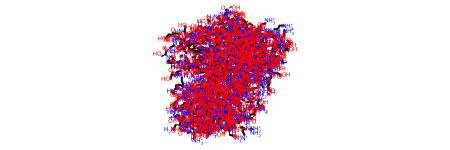

In [78]:
pocket_mol

In [102]:
def BFS_for_ligand_components(mol: Chem.Mol, ligand_indices: list) -> list:
    """
    Args: 

    mol: RDKit molecule object. 

    ligand_indices: list of indices of ligand atoms in the molecule.    

    Returns:

    list of components that partition the ligand atoms in the molecule to atoms that are within POCKET_THRESHOLD distance from each other. 
    data structure: list of lists of atom indices.
    """

    # Initialize the components list
    components = []

    # Initialize the visited list
    visited = [False] * len(ligand_indices)

    # Initialize the queue
    queue = []

    # Iterate over the ligand atoms
    for ligand_idx, atom_idx in enumerate(ligand_indices):
        # If the atom has already been visited, skip it
        if visited[ligand_idx]:
            continue

        # Add the atom to the queue
        queue.append(ligand_idx)

        # Initialize the component list
        component = []

        # While the queue is not empty
        while len(queue) > 0:

            # Pop the atom index from the queue
            curr_ligand_idx = queue.pop(0)
            curr_atom_idx = ligand_indices[curr_ligand_idx]

            # If the atom has already been visited, skip it
            if visited[curr_ligand_idx]:
                continue

            # Mark the atom as visited
            visited[curr_ligand_idx] = True

            # Add the atom to the component
            component.append(curr_ligand_idx)

            # Iterate over all ligand atoms 
            for neigh_ligand_idx_2, neigh_atom_idx in enumerate(ligand_indices):

                # If the neighbor has already been visited, skip it
                if visited[neigh_ligand_idx_2]:
                    continue

                # If the distance between the atoms is less than the threshold
                if mol.GetConformer().GetAtomPosition(neigh_atom_idx).Distance(mol.GetConformer().GetAtomPosition(curr_atom_idx)) < POCKET_THRESHOLD:
                    # Add the neighbor to the queue
                    queue.append(neigh_ligand_idx_2)

        # Add the component to the components list
        components.append(component)

    return components

In [106]:
def find_pocket_residues_RDKit(mol: Chem.Mol, protein_or_ligand_ids: list):
    # Identify ligand atoms
    ligand_atom_indices = [atom.GetIdx() for atom in mol.GetAtoms() if protein_or_ligand_ids[atom.GetIdx()] == 1]
    print(len(ligand_atom_indices))

    ligand_components = BFS_for_ligand_components(mol, ligand_atom_indices)

    pocket_residue_indices = set()  
    pocket_atom_indices = set(ligand_atom_indices)  

    for ligand_component in ligand_components:

        # Get coordinates of ligand atoms
        ligand_coords = get_atom_coordinates(mol)[ligand_component]
        # Compute the centroid of the ligand atoms
        ligand_centroid = np.mean(ligand_coords, axis=0)
        
        print(max(np.linalg.norm(ligand_coords - ligand_centroid, axis=1)))
        print(POCKET_THRESHOLD)

        # Compute the maximum distance from the centroid to any ligand atom
        max_distance = max(np.linalg.norm(ligand_coords - ligand_centroid, axis=1)) + POCKET_THRESHOLD  # Adding threshold to the max distance

        # Get coordinates of all atoms
        all_coords = get_atom_coordinates(mol)
        
        # Loop over protein atoms and check if they are within the bounding sphere
        for p_atom in tqdm(mol.GetAtoms()):
            p_idx = p_atom.GetIdx()
            if p_idx >= num_atoms_in_protein:  # Skip ligand atoms
                continue
            
            distance_to_centroid = np.linalg.norm(all_coords[p_idx] - ligand_centroid)
            if distance_to_centroid <= max_distance:
                pocket_residue_indices.add(p_atom.GetPDBResidueInfo().GetResidueNumber())
                        
        # Add all atoms of the identified residues
        for atom in mol.GetAtoms():
            if atom.GetPDBResidueInfo().GetResidueNumber() in pocket_residue_indices:
                pocket_atom_indices.add(atom.GetIdx())
    
    return list(pocket_atom_indices)

In [108]:
pocket_atom_indices = find_pocket_residues_RDKit(complex_mol, protein_or_ligand_ids)
    
# Create a new mol object with only pocket atoms
pocket_mol = create_pocket_mol(complex_mol, pocket_atom_indices)

# Save the new mol to a file
output_filename = "../../test_data/pdb/1a0q/1a0q_complex_spheroid_pocket_residues.sdf"
save_mol_to_sdf(pocket_mol, output_filename)

# Save the new mol to a pdb file
output_filename = "../../test_data/pdb/1a0q/1a0q_complex_spheroid_pocket_residues.pdb"
save_mol_to_pdb(pocket_mol, output_filename)

26
0.0
10


100%|██████████| 3209/3209 [00:00<00:00, 185395.41it/s]


0.0
10


100%|██████████| 3209/3209 [00:00<00:00, 199862.22it/s]


0.0
10


100%|██████████| 3209/3209 [00:00<00:00, 188751.91it/s]


6.375267187254549
10


100%|██████████| 3209/3209 [00:00<00:00, 181493.01it/s]


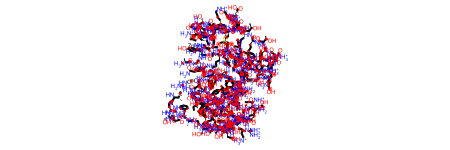

In [109]:
pocket_mol

In [81]:
counter = 0 
for atom in complex_mol.GetAtoms():
    if atom.GetPDBResidueInfo().GetIsHeteroAtom():
        print(atom.GetPDBResidueInfo().GetResidueNumber(), atom.GetSymbol(), atom.GetIdx())
        print(atom.GetPDBResidueInfo().GetIsHeteroAtom())
        print(atom.GetPDBResidueInfo().GetChainId())    
        counter += 1

1 Zn 3183
True
B
2 Zn 3184
True
B
3 Zn 3185
True
B
1 C 3186
True
A
1 C 3187
True
A
1 C 3188
True
A
1 C 3189
True
A
1 C 3190
True
A
1 C 3191
True
A
1 C 3192
True
A
1 C 3193
True
A
1 C 3194
True
A
1 C 3195
True
A
1 C 3196
True
A
1 C 3197
True
A
1 C 3198
True
A
1 C 3199
True
A
1 C 3200
True
A
1 O 3201
True
A
1 O 3202
True
A
1 O 3203
True
A
1 O 3204
True
A
1 O 3205
True
A
1 O 3206
True
A
1 N 3207
True
A
1 P 3208
True
A


In [82]:
counter

26